## <center>inspired by this tweet https://twitter.com/MEKhoko/status/981868845794283520</center>

<img src="fundstrat.jpg">

In [1]:
%matplotlib inline
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = quandl.get("BCHAIN/MKPRU")

In [3]:
data.head()

,Value
Date,
2009-01-03,0.0
2009-01-04,0.0
2009-01-05,0.0
2009-01-06,0.0
2009-01-07,0.0


In [4]:
data.loc[data['Value'] > 0].head()

,Value
Date,
2010-08-17,0.076900
2010-08-18,0.074000
2010-08-19,0.068800
2010-08-20,0.066700
2010-08-21,0.066899


In [5]:
data = data.loc['2010-08-17':]

In [6]:
data.head()

,Value
Date,
2010-08-17,0.076900
2010-08-18,0.074000
2010-08-19,0.068800
2010-08-20,0.066700
2010-08-21,0.066899


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2790 entries, 2010-08-17 to 2018-04-06
Data columns (total 1 columns):
Value    2790 non-null float64
dtypes: float64(1)
memory usage: 43.6 KB


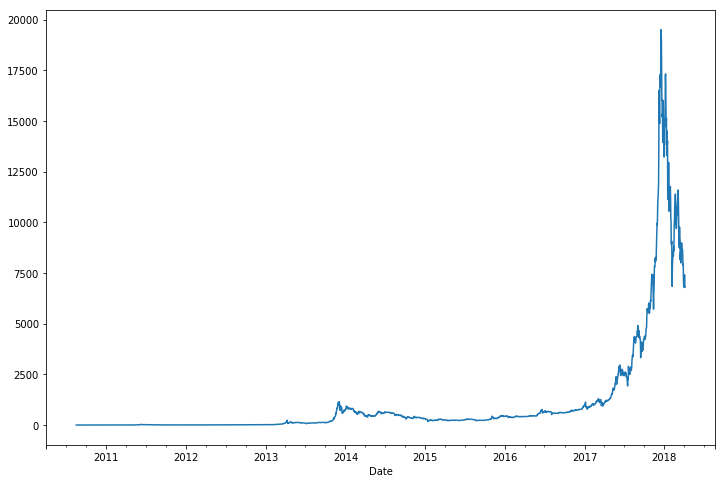

In [8]:
data['Value'].plot(figsize=(12,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112363610>]],
      dtype=object)

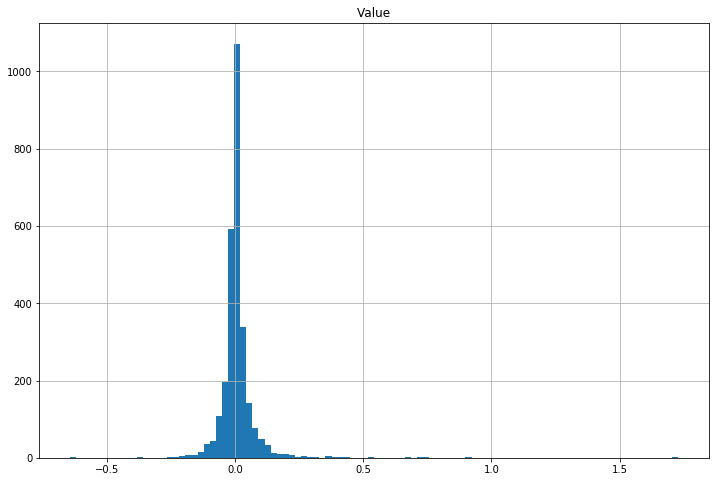

In [9]:
data.pct_change().hist(bins=100, figsize = (12,8))

In [10]:
# best and worst days
data['Value'].pct_change().dropna().sort_values().head()

Date
2010-09-16   -0.646286
2013-04-12   -0.380167
2013-04-11   -0.376763
2010-11-08   -0.259999
2010-10-12   -0.239047
Name: Value, dtype: float64

In [11]:
data_annual = data.asfreq("Y")
data_annual['Returns'] = data_annual['Value'].pct_change() * 100
data_annual.index = data_annual.index.year
data_annual.dropna(inplace=True)

In [12]:
data_annual['Returns'].head(10)

Date
2011    1565.005550
2012     172.072072
2013    5278.955114
2014     -56.580027
2015      34.845621
2016     122.464953
2017    1287.971853
Name: Returns, dtype: float64

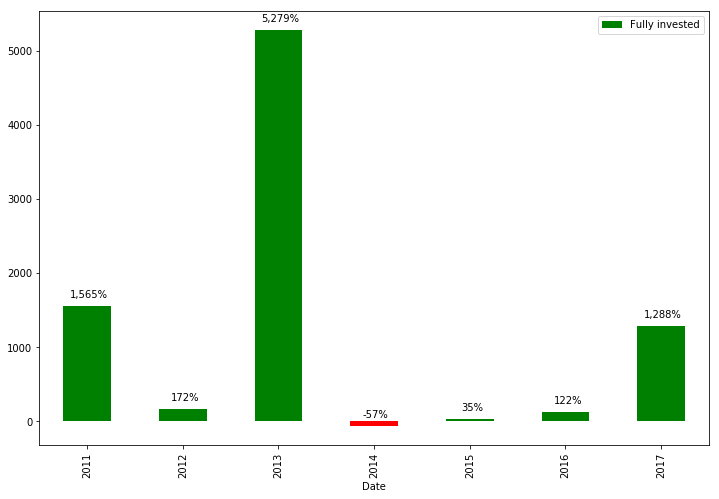

In [13]:
colors = np.sign(data_annual['Returns']).map({1 : 'g', -1 : 'r'}).values
ax = data_annual['Returns'].plot(kind='bar', figsize=(12,8),color = colors)
ax.legend(["Fully invested"]);
for p in ax.patches:
    b = p.get_bbox()
    val = "{:,.0f}%".format(b.y1 + b.y0)        
    ax.annotate(val,((b.x0 + b.x1) / 2 + len(val) * -0.03, b.y1 + 110))

In [14]:
data['Returns'] = data['Value'].pct_change()
data.dropna(inplace = True)
returns_by_year = data.groupby(lambda x: x.year)

In [15]:
data_annual['MissTop10'] = 0.0
data_annual['MissTop5'] = 0.0

for year, frame in returns_by_year:
    
    full_return = (frame['Returns'] + 1).cumprod()[-1] - 1
    top10 = frame['Returns'].sort_values()[-10:]
    top5 = top10[-5:]
    top10_return = (top10 + 1).cumprod()[-1] - 1
    top5_return = (top5 + 1).cumprod()[-1] - 1
    full_less_top10_return = ((1 + full_return) / (1 + top10_return)) - 1
    full_less_top5_return = ((1 + full_return) / (1 + top5_return)) - 1
    
    data_annual.loc[year, 'MissTop10'] = full_less_top10_return * 100
    data_annual.loc[year, 'MissTop5'] = full_less_top5_return * 100
    
    print year, '-' * 30 
    print "Full year return {:,.0f}%".format(full_return * 100 )
    print "top 10 days return {:,.0f}%".format(top10_return * 100)
    print "Return if miss 10 top days {:,.0f}%".format(full_less_top10_return * 100)
    
    

2010 ------------------------------
Full year return 290%
top 10 days return 4,403%
Return if miss 10 top days -91%
2011 ------------------------------
Full year return 1,565%
top 10 days return 3,489%
Return if miss 10 top days -54%
2012 ------------------------------
Full year return 172%
top 10 days return 203%
Return if miss 10 top days -10%
2013 ------------------------------
Full year return 5,279%
top 10 days return 798%
Return if miss 10 top days 499%
2014 ------------------------------
Full year return -57%
top 10 days return 205%
Return if miss 10 top days -86%
2015 ------------------------------
Full year return 35%
top 10 days return 175%
Return if miss 10 top days -51%
2016 ------------------------------
Full year return 122%
top 10 days return 113%
Return if miss 10 top days 4%
2017 ------------------------------
Full year return 1,288%
top 10 days return 313%
Return if miss 10 top days 236%
2018 ------------------------------
Full year return -48%
top 10 days return 148%

In [16]:
data_annual.dropna(inplace = True)
data_annual.head(10)

,Value,Returns,MissTop10,MissTop5
Date,,,,
2011,4.995,1565.005550,-53.610527,76.179178
2012,13.590,172.072072,-10.122086,42.163253
2013,731.000,5278.955114,499.187027,1357.619774
2014,317.400,-56.580027,-85.757641,-77.870400
2015,428.000,34.845621,-50.981745,-30.398076
2016,952.150,122.464953,4.400957,37.428486
2017,13215.574,1287.971853,236.421711,499.261883


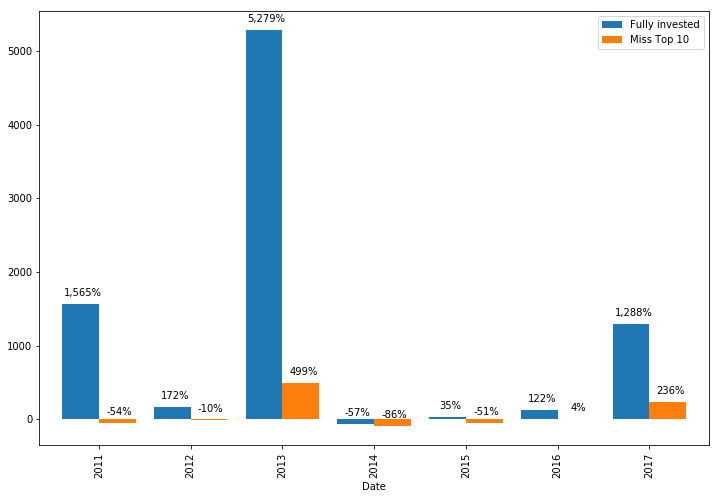

In [19]:
ax = data_annual[['Returns','MissTop10']].plot(kind='bar', figsize=(12,8), width = 0.8)
ax.legend(["Fully invested", "Miss Top 10"]);
x_offset, y_offset = -0.03, 110
for p in ax.patches:
    b = p.get_bbox()
    val = "{:,.0f}%".format(b.y1 + b.y0)        
    ax.annotate(val,((b.x0 + b.x1) / 2 + len(val) * x_offset, b.y1 + y_offset))


In [20]:
print "Compound annual returns"
print "-" * 25
print "Fully invested since start 2011 {:,.0f}%".format((((data_annual['Returns'] / 100 + 1).cumprod().iloc[-1]) ** (1.0/len(data_annual)) - 1) * 100)
print "Missed top 10 each year {:,.0f}%".format((((data_annual['MissTop10'] / 100 + 1).cumprod().iloc[-1]) ** (1.0/len(data_annual)) - 1) * 100)
print "Missed top 5 each year {:,.0f}%".format((((data_annual['MissTop5'] / 100 + 1).cumprod().iloc[-1]) ** (1.0/len(data_annual)) - 1) * 100)

Compound annual returns
-------------------------
Fully invested since start 2011 361%
Missed top 10 each year -7%
Missed top 5 each year 73%


In [21]:
# sanity check on 2013 returns
start2013, end2013 = data.loc['2012-12-31','Value'], data.loc['2013-12-31','Value']
print start2013, end2013
print (end2013 / start2013 - 1) * 100
print ((data.loc['2013-1-1':'2013-12-31','Returns'] + 1).cumprod()[-1] - 1) * 100

# check a few days before and after
print data.loc['2012-12-25':'2013-01-5','Value']
print data.loc['2013-12-25':'2014-01-5','Value']

13.59 731.0
5278.955114054452
5278.95511405445
Date
2012-12-25    13.45000
2012-12-26    13.39890
2012-12-27    13.47000
2012-12-28    13.64990
2012-12-29    13.67000
2012-12-30    13.56998
2012-12-31    13.59000
2013-01-01    13.56100
2013-01-02    13.40000
2013-01-03    13.46400
2013-01-04    13.48986
2013-01-05    13.54800
Name: Value, dtype: float64
Date
2013-12-25    658.07
2013-12-26    734.42
2013-12-27    715.51
2013-12-28    701.61
2013-12-29    714.79
2013-12-30    739.10
2013-12-31    731.00
2014-01-01    746.90
2014-01-02    758.01
2014-01-03    806.21
2014-01-04    822.38
2014-01-05    896.00
Name: Value, dtype: float64
